### Transfer learning in image classification
In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#!pip install --upgrade tensorflow_hub

In [3]:
IMAGE_SHAPE = (224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4',input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [5]:
data_dir = ('C:\\Users\\jaych\\Downloads\\iAnalyst\\Deep Learning\\flower\\datasets\\flower_photos\\')

In [7]:
type(data_dir )

str

In [8]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/jaych/Downloads/iAnalyst/Deep Learning/flower/datasets/flower_photos')

In [9]:
type(data_dir)

pathlib.WindowsPath

In [15]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [16]:
roses = list(data_dir.glob('roses/*'))
roses[:2]

[WindowsPath('C:/Users/jaych/Downloads/iAnalyst/Deep Learning/flower/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('C:/Users/jaych/Downloads/iAnalyst/Deep Learning/flower/datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg')]

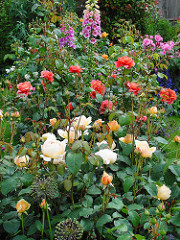

In [20]:
Image.open(roses[-3])

#### Read flowers images from disk into numpy array using opencv

In [28]:
flowers_image_dict  = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [23]:
flowers_label_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [33]:
img = cv2.imread(str(flowers_image_dict['tulips'][-1]))
img.shape

(335, 500, 3)

In [35]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [54]:
from tqdm import tqdm
X,y = [],[]
for flower_name, images in tqdm(flowers_image_dict.items()):
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_label_dict[flower_name])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]


In [55]:
X = np.array(X)
y = np.array(y)

#### Train test Split

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=101)

#### Preprocessing : Scaling images

In [57]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

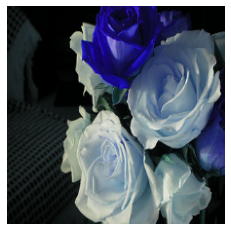

In [58]:
plt.axis('off')
plt.imshow(X[1])

#### Make prediction using pre-trained model on new flowers dataset

In [59]:
predicted =  classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 880, 795], dtype=int64)

### Now take pre-trained model and retrain it using flowers images

In [61]:
feature_extracter_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model_without_top_layer = hub.KerasLayer(feature_extracter_model,
                                                   input_shape=(224,224,3),trainable=False)

In [68]:
num_of_flowers =5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics='accuracy')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [69]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 67s 719ms/step - loss: 0.8085 - accuracy: 0.7068
Epoch 2/5
86/86 [==============================] - 57s 661ms/step - loss: 0.4189 - accuracy: 0.8554
Epoch 3/5
86/86 [==============================] - 56s 657ms/step - loss: 0.3236 - accuracy: 0.8924
Epoch 4/5
86/86 [==============================] - 56s 656ms/step - loss: 0.2704 - accuracy: 0.9106
Epoch 5/5
86/86 [==============================] - 54s 632ms/step - loss: 0.2311 - accuracy: 0.9310


In [70]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 21s 678ms/step - loss: 0.3915 - accuracy: 0.8758


[0.3915444612503052, 0.8758170008659363]